# Transfer Learning with TensorFlow Part 2: Fine-tuning 👀

In [5]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Create helper functions

It a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [7]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-02-09 21:11:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-09 21:11:51 (75.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [8]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-09 21:11:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.3MB/s    in 8.1s    

2024-02-09 21:12:01 (19.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



## Let's get some data

This time we'll see how we can use pretrained models. <br>
Within `tf.keras.applications` and apply tem to ourown problem. <br>
We qill use `10%` of food data.

In [9]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [10]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> Using new way of ImageDataGenerator 🐼

In [12]:
# Check out the class names of our class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is stright-forward, it runs our layers in sequential order.

But thefunctional API gives more flexibility with our models.  🖥️

In [13]:
tf.random.set_seed(42)

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# 4. If using a model like ResNet50V2 you need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing inputs hrough base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePoolingLayers")(x)
print(f"Shape after GlobalAveragePooling: {x.shape}")

# 7. Create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="Output_layer")(x)

# 8. Combine the imputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile a model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent =  model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="TransferLearning", experiment_name="10percnt_feature_extraction")]) #Validation only 25% for time saving

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs hrough base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling: (None, 1280)
Saving TensorBoard log files to: TransferLearning/10percnt_feature_extraction/20240209-211237
Epoch 1/5
24/24 [==============================] - 17s 284ms/step - loss: 1.8172 - accuracy: 0.4627 - val_loss: 1.2551 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 4s 132ms/step - loss: 1.0759 - accuracy: 0.7600 - val_loss: 0.8619 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 3s 129ms/step - loss: 0.7761 - accuracy: 0.8200 - val_loss: 0.7048 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 5s 177ms/step - loss: 0.6364 - accuracy: 0.8533 - val_loss: 0.5967 - val_accuracy: 0.8734
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5395 - accuracy: 0.8813 - val_loss: 0.5529 - val_accuracy: 0.8586


In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.5534 - accuracy: 0.8596


[0.5534180402755737, 0.8596000075340271]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [16]:
# How about we get a sunmmary of our base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [17]:
# How about of our model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayers  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


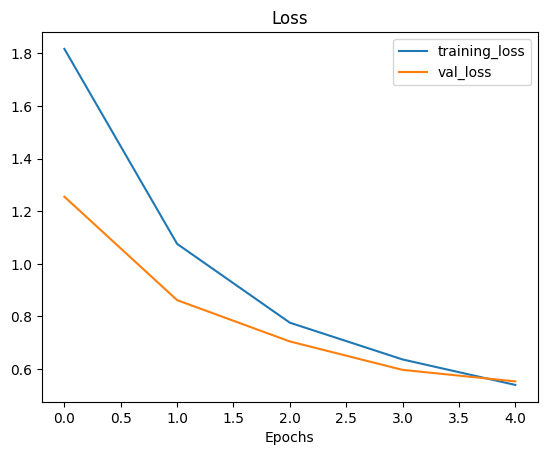

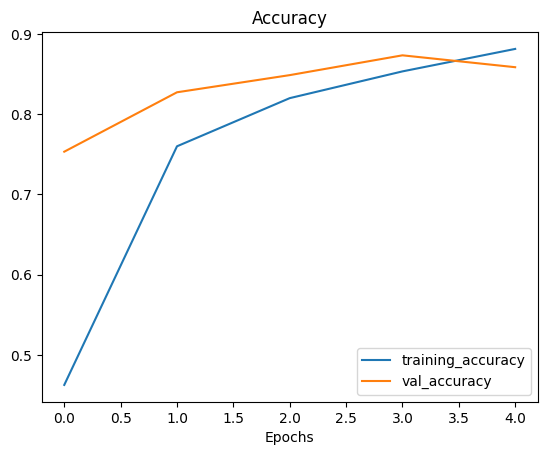

In [18]:
# Check out our model training curves
plot_loss_curves(history=history_10_percent)

## Getting a feature vector from a trained model

Let's demostrate the Gloval Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

Then when it pass through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shape tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [19]:
# Define the input shape
input_shape=(1, 4, 4 ,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(input_tensor, "\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor)

tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32) 

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


> shape(1, 4, 4, 3) -> (1, 3). From 4D to 2D. 🔨

In [20]:
# Let's replocate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a Series of Transfer Learning Experiments

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑 **Note:** All experiments the same dataset will be used to evaluate our model. This ensure coonsistency across evaluation metrics.

### Getting and preprocessing data for model_1 🖥️

In [21]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-02-09 21:14:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.5MB/s    in 6.7s    

2024-02-09 21:14:19 (19.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [23]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [24]:
# Setup data and loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # Default

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # Default

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` <br><br><br>

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation happens only during training, so we can use it elsewhere.

In [25]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
])

### Visualize our data augmentation layer (and see what happens to our data) 🥹

(-0.5, 508.5, 511.5, -0.5)

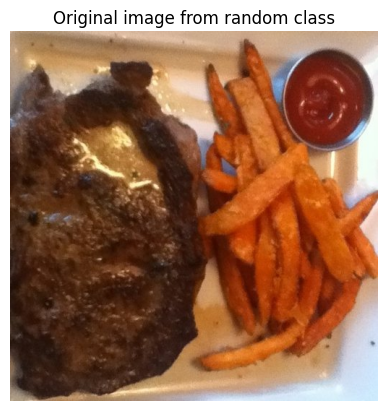

In [26]:
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
image = mpimg.imread(random_image_path)
plt.imshow(image)
plt.title("Original image from random class")
plt.axis(False)

# Modle 1 : Feature extration transfer learning on 1% of the data with data augmentation

In [27]:
tf.random.set_seed(42)

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentaion as a layer
x = data_augmentation(inputs)

# Give base model an input
x = base_model(x , training=False)

# Pool te output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="PoolingLayers")(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_1 = tf.keras.Model(inputs, outputs)

# Compile a model
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

# Fit the data
history_1_percent_model_1 = model_1.fit(
    train_data_1_percent,
    steps_per_epoch=len(train_data_1_percent),
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="TransferLearning", experiment_name="1percnt_feature_extraction")]
)


Saving TensorBoard log files to: TransferLearning/1percnt_feature_extraction/20240209-211523
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3604 - accuracy: 0.0714 - val_loss: 2.2134 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.0966 - accuracy: 0.2571 - val_loss: 2.0923 - val_accuracy: 0.2697
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8815 - accuracy: 0.3571 - val_loss: 1.9765 - val_accuracy: 0.3487
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.6935 - accuracy: 0.5857 - val_loss: 1.8857 - val_accuracy: 0.3947
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5478 - accuracy: 0.6857 - val_loss: 1.7704 - val_accuracy: 0.4655


In [28]:
# Evaluate on the full test dataset
reault_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 1.7845 - accuracy: 0.4584


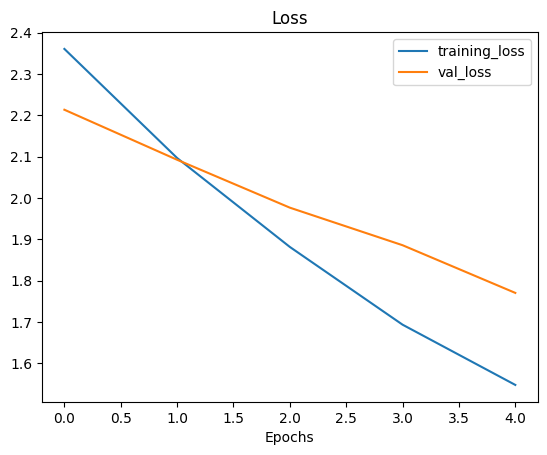

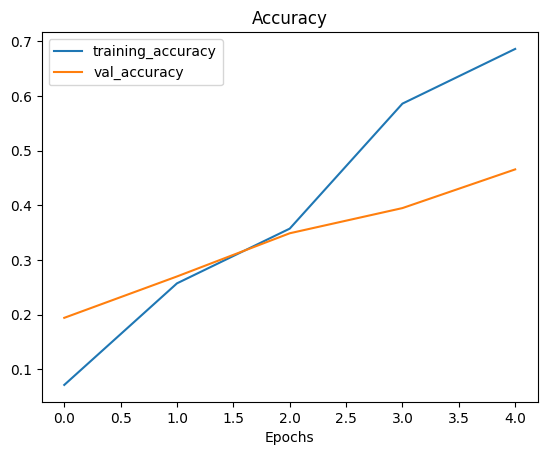

In [29]:
# How do the model go with 1% data augmentation?
plot_loss_curves(history_1_percent_model_1)

## Model 2 with 10% of data with augmentation

In [33]:
tf.random.set_seed(42)

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentaion as a layer
x = data_augmentation(inputs)

# Give base model an input
x = base_model(x , training=False)

# Pool te output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="PoolingLayers")(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_2 = tf.keras.Model(inputs, outputs)

# Compile a model
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

Saving TensorBoard log files to: TransferLearning/10percnt_feature_extraction/20240209-212525
Epoch 1/5
24/24 [==============================] - 23s 636ms/step - loss: 2.0054 - accuracy: 0.3133 - val_loss: 1.4361 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - 15s 580ms/step - loss: 1.3184 - accuracy: 0.6827 - val_loss: 0.9787 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 13s 528ms/step - loss: 0.9939 - accuracy: 0.7733 - val_loss: 0.7710 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 12s 476ms/step - loss: 0.8358 - accuracy: 0.7853 - val_loss: 0.6578 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 14s 570ms/step - loss: 0.7240 - accuracy: 0.8227 - val_loss: 0.5976 - val_accuracy: 0.8651


### Creating a `ModelCheckpoint` callback

The `ModelMheckpoint` callback intermediately saves our model(the full model or gust the weights) during training. <br>
This is useful so we can come and start where we left over.

In [36]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that save model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [37]:
# Fitting the model 2
initial_epochs = 5
history_10_percent_model_2 = model_2.fit(train_data_10_percent,
                                         epochs = initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="TransferLearning",
                                                                                experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: TransferLearning/10_percent_data_aug/20240209-214313
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.8440
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 623ms/step - loss: 0.6512 - accuracy: 0.8440 - val_loss: 0.5695 - val_accuracy: 0.8618
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.8533
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 483ms/step - loss: 0.5914 - accuracy: 0.8533 - val_loss: 0.5447 - val_accuracy: 0.8651
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.8693
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 569ms/step - loss: 0.5528 - accuracy: 0.8693 - val_loss: 0.5197 - val_accuracy: 0.8668
Ep

In [44]:
# Test model 2
result_10_percent_aug = model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.4969 - accuracy: 0.8588


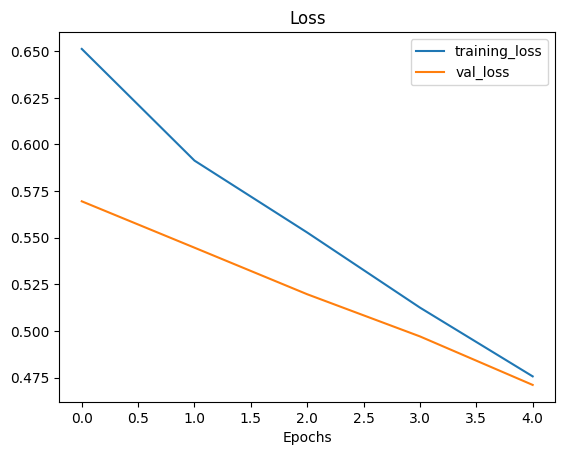

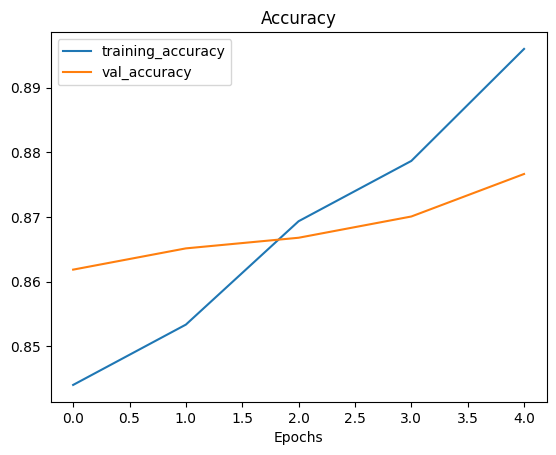

In [45]:
# Plot the loss curves
plot_loss_curves(history_10_percent_model_2)

### Loading in checkpointed weights

In [46]:
model_2.load_weights(checkpoint_path)

In [47]:
# Evaluate model_2 with loaded weights
loaded_weights_model = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4969 - accuracy: 0.8588


In [48]:
loaded_weights_model == result_10_percent_aug

True